In [23]:
import random
import math
import sklearn.tree
import matplotlib.pyplot as plt

Firstly we bring the Car Evaluation Data Set. We need to encode nominal attributes for sklearn.

In [17]:
instances = []
labels = []
with open("Car Evaluation Data Set/car.data", "r") as f:
    for line in f.readlines():
        buying, maint, doors, persons, lug_boot, safety, label = line.split(",")
        # Ordinal Encoding
        instance = [
            ["low", "med", "high", "vhigh"].index(buying),
            ["low", "med", "high", "vhigh"].index(maint),
            ["2", "3", "4", "5more"].index(doors),
            ["2", "4", "more"].index(persons),
            ["small", "med", "big"].index(lug_boot),
            ["low", "med", "high"].index(safety)
        ]
        labels.append(label)
        instances.append(instance)

Now we define a new function to randomly partition the labeled instances into data set and test set. The ratio of data set to the labeled instances is passed as an argument. 

In [71]:
def holdout_partition(split_ratio):
    instances_size = len(instances)
    data_set_size = math.floor(split_ratio * instances_size)
    data_set_indices = set(random.sample(range(instances_size), data_set_size))
    data_set = []
    data_set_labels = []
    test_set = []
    test_set_labels = []
    for i in range(instances_size):
        if i in data_set_indices:
            data_set.append(instances[i])
            data_set_labels.append(labels[i])
        else:
            test_set.append(instances[i])
            test_set_labels.append(labels[i])
    return data_set, data_set_labels, test_set, test_set_labels

In [84]:
def test_model(model, test_set, test_set_labels):
    predicted_labels = model.predict(test_set)
    correct_predictions = 0
    n = len(test_set)
    for i in range(len(test_set)):
        if test_set_labels[i] == predicted_labels[i]:
            correct_predictions += 1
    wrong_predictions = n - correct_predictions
    return wrong_predictions / n, wrong_predictions

In [78]:
def build_model(data_set, data_set_labels, **model_options):
    return sklearn.tree.DecisionTreeClassifier(**model_options).fit(data_set, data_set_labels)

In [80]:
def holdout_method(holdout_split_ratio, **model_options):
    data_set, data_set_labels, test_set, test_set_labels = holdout_partition(holdout_split_ratio)
    model = build_model(data_set, data_set_labels, **model_options)
    training_error, _ = test_model(model, data_set, data_set_labels)
    test_error, _ = test_model(model, test_set, test_set_labels)
    return model, training_error, test_error

In [102]:
def k_fold_partition(k):
    remaining = instances.copy()
    remaining_labels = labels.copy()
    folds = []
    fold_size = math.floor(len(instances) / k)
    for i in range(k - 1):
        remaining_size = len(remaining)
        fold_indices = set(random.sample(range(remaining_size), fold_size))
        fold = []
        fold_labels = []
        for j in range(remaining_size, -1, -1):
            if j in fold_indices:
                fold.append(remaining[j])
                fold_labels.append(remaining_labels[j])
                del remaining[j], remaining_labels[j]
        folds.append((fold, fold_labels))
    folds.append((remaining, remaining_labels))
    return folds

In [121]:
def cross_validation_method(k, **model_options):
    folds = k_fold_partition(k)
    best_model = None
    best_error = None
    total_wrong_predictions = 0
    for i in range(k):
        test_set, test_set_labels = folds[i]
        data_set, data_set_labels = [], []
        for j in range(k):
            if j == i:
                continue
            fold, fold_labels = folds[j]
            data_set.extend(fold)
            data_set_labels.extend(fold_labels)
        model = build_model(data_set, data_set_labels, **model_options)
        error_rate, wrong_predictions = test_model(model, test_set, test_set_labels)
        total_wrong_predictions += wrong_predictions
        if best_model:
            if error_rate < best_error:
                best_model = model
                best_depth = error_rate
        else:
            best_model = model
            best_error = error_rate
    return best_model, total_wrong_predictions / len(instances)

In [110]:
def prepare_holdout_errors(holdout_split_ratio, begin_leaf_nodes, end_leaf_nodes):
    training_errors = []
    test_errors = []
    leaf_nodes = []
    for i in range(begin_leaf_nodes, end_leaf_nodes):
        model, training_error, test_error = holdout_method(holdout_split_ratio, max_leaf_nodes = i)
        training_errors.append(training_error)
        test_errors.append(test_error)
        leaf_nodes.append(i)
    return training_errors, test_errors, leaf_nodes

In [135]:
def prepare_cross_validation_errors(k_begin, k_end):
    test_errors = []
    wtf_errors = [] 
    fold_counts = range(k_begin, k_end)
    for k in range(k_begin, k_end):
        best_model, test_error = cross_validation_method(k)
        test_errors.append(test_error) # cross validation test error
        error_on_instances, _ = test_model(best_model, instances, labels)
        wtf_errors.append(error_on_instances) # best model error on the entire labeled set
    return fold_counts, test_errors, wtf_errors

In [138]:
def plot_errors():
    fig, ax = plt.subplots(1, 2, figsize = (15, 5))
    training_errors, test_errors, leaf_nodes = prepare_holdout_errors(0.7, 2, 200)
    ax1 = ax[0]
    ax1.plot(leaf_nodes, training_errors, label="training errors")
    ax1.plot(leaf_nodes, test_errors, label="test errors")
    ax1.legend()
    ax1.set_xlabel("leaf nodes")
    ax1.set_ylabel("error")
    ax1.set_title("Holdout Method")
    ax2 = ax[1]
    fold_counts, test_errors, wtf_errors = prepare_cross_validation_errors(2, 20)
    ax2.plot(fold_counts, test_errors, label="cross validation test error")
    ax2.plot(fold_counts, wtf_errors, label="best model error on the entire labeled set")
    ax2.set_xlabel("k")
    ax2.set_ylabel("error")
    ax2.legend()
    ax2.set_title("k-Fold Cross Validation")

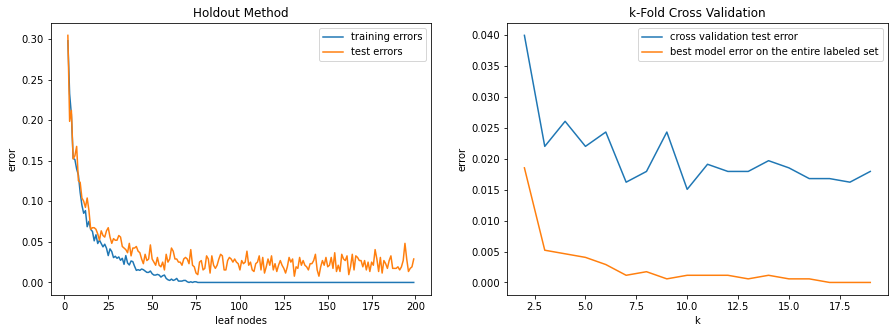

In [139]:
plot_errors()